# Braille Translation
### Christina Carr and Mariam Germanyan
____________________________
This project sought to create an image translation system for English Braille. Our first model takes in images of English Braille words, splits them into their component characters, and translates them into the English Latin alphabet in a method reminiscent of optical character recognition. 

# Imports

In [1]:
import matplotlib.pyplot as plt
import PIL
import numpy as np
from PIL import Image
import os
import glob

from matplotlib import cm

%matplotlib inline

# Import a bunch of libraries.
import time
from sklearn.cluster import KMeans
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from shutil import copyfile
from pybraille import convertText

from nltk.corpus import words
import collections
import enchant
import csv
import math, collections
import pandas as pd
import re
import itertools
import nltk
import nltk.data
nltk.download('words')
import string
nltk.download('brown')
from tensorflow.keras.preprocessing import image
from scipy import ndimage, misc
import cv2

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

[nltk_data] Downloading package words to /Users/mariam/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package brown to /Users/mariam/nltk_data...
[nltk_data]   Package brown is already up-to-date!


# Approach 1: Preprocessing Data at the Sentence Level
### Reading in sentences that we created

In [21]:
path = os.getcwd() + '/test_words'
def read_files(path):

    all_files = glob.glob(path + "/*.png")

    sentences = []
    images = []
    for filename in all_files:
        with Image.open(filename) as img:
            sentence = os.path.basename(os.path.normpath(os.path.splitext(filename)[0]))
            sentences.append(sentence)
            first = np.array(img)[:,:,0].T[0:28].T
            second = np.array(img)[:,:,0].T[28:56].T
            third = np.array(img)[:,:,0].T[56:].T
            first = cv2.cvtColor(first, cv2.COLOR_GRAY2BGR)
            second = cv2.cvtColor(second, cv2.COLOR_GRAY2BGR)
            third = cv2.cvtColor(third, cv2.COLOR_GRAY2BGR)
            images.append([Image.fromarray(first), Image.fromarray(second), Image.fromarray(third)])
    return sentences, images


In [22]:
english_words, braille_images = read_files(path)

In [15]:
english_words[0]

'hyp'

In [13]:
braille_images[0][0]


In [14]:
braille_images[0][1]

In [17]:
braille_images[0][2]

In [ ]:
# code that was used to convert the corpus of words into braille images as input
# path = os.getcwd() + '/test_words/'
# #os.mkdir(path)

# def get_concat_h(im1, im2):
#     dst = Image.new('RGB', (im1.width + im2.width, im1.height))
#     dst.paste(im1, (0, 0))
#     dst.paste(im2, (im1.width, 0))
#     return dst

# for word in test:
#     img1 = Image.open(os.getcwd() + '/266 Photos/test/'+ word[0] + '.png')
#     img2 =  Image.open(os.getcwd() + '/266 Photos/test/' + word[1] + '.png')
#     img3 =  Image.open(os.getcwd() + '/266 Photos/test/'+ word[2] +'.png')
#     half_image = get_concat_h(img1, img2)
#     full_image = get_concat_h(half_image, img3)
#     full_image.save(path + word + '.png')

In [70]:
# Get the images into corresponding folders and filter out some data.

In [24]:
# os.mkdir('./images/')

# alpha = 'a'
# for i in range(0, 26): 
#     os.mkdir('./images/' + alpha)
#     alpha = chr(ord(alpha) + 1)

# rootdir = os.getcwd() + '/archive/Braille Dataset/Braille Dataset/'
# for file in os.listdir(rootdir):
#     letter = file[0]
#     copyfile(rootdir+file, './images/' + letter + '/' + file)

In [25]:
# path = os.getcwd() + '/archive/Braille Dataset/Braille Dataset/'
# all_files = glob.glob(path + "/*.jpg") 
# for file_path in all_files:
#     if file_path[-7:-4] == 'rot':
#         os.remove(file_path)
# path = os.getcwd() + '/archive/Braille Dataset/Braille Dataset/'
# all_files = glob.glob(path + "/*.jpg") 
# for file_path in all_files:
#     if file_path[-7:-4] == 'dim':
#         os.remove(file_path)

# Pre-existing Model Training on kaggle data at the individual character level

In [26]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(validation_split=0.3)

train_generator = datagen.flow_from_directory('./images/',
                                              target_size=(28,28),
                                              subset='training')

val_generator = datagen.flow_from_directory('./images/',
                                            target_size=(28,28),
                                            subset='validation')


Found 364 images belonging to 26 classes.
Found 156 images belonging to 26 classes.


In [27]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

K.clear_session()

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)
early_stop = EarlyStopping(patience=15,verbose=1)

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(26,activation='softmax')(x)

model = Model(entry,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              epochs=60,
                              callbacks=[model_ckpt,reduce_lr,early_stop],
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
12/12 [==============================] - 1s 56ms/step - loss: 3.3212 - accuracy: 0.0330 - val_loss: 3.2737 - val_accuracy: 0.0385
Epoch 2/60
12/12 [==============================] - 0s 29ms/step - loss: 3.2764 - accuracy: 0.0275 - val_loss: 3.2646 - val_accuracy: 0.0833
Epoch 3/60
12/12 [==============================] - 0s 36ms/step - loss: 3.2543 - accuracy: 0.0495 - val_loss: 3.2417 - val_accuracy: 0.0385
Epoch 4/60
12/12 [==============================] - 0s 33ms/step - loss: 3.2139 - accuracy: 0.0687 - val_loss: 3.1913 - val_accuracy: 0.0705
Epoch 5/60
12/12 [==============================] - 0s 32ms/step - loss: 3.1183 - accuracy: 0.1538 - val_loss: 3.0554 - val_accuracy: 0.1218
Epoch 6/60
12/12 [==============================] - 0s 30ms/step - loss: 2.8974 - accuracy: 0.1538 - val_loss: 2.8142 - val_accuracy: 0.1603
Epoch 7/60
12/12 [==============================] - 0s 31ms/step - loss: 2.485

In [28]:
alphabet = []
alpha = 'a'
for i in range(0, 26): 
    alphabet.append(alpha)
    alpha = chr(ord(alpha) + 1)

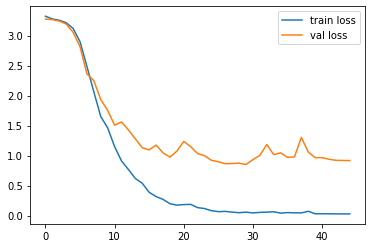

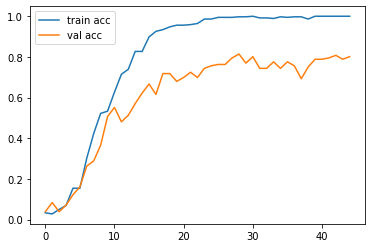

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

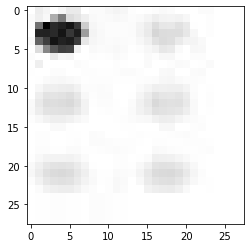

In [77]:
# kaggle data for the letter a
from tensorflow.keras.preprocessing import image
img=image.load_img( os.getcwd() + '/archive/Braille Dataset/Braille Dataset/a1.JPG10whs.jpg')
plt.imshow(img)

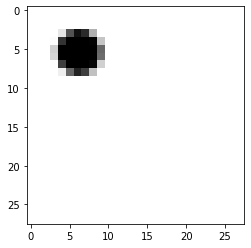

In [78]:
# our data for the letter a from brailletranslator.org
img = image.load_img( os.getcwd() + '/266 Photos/test/a.png')
plt.imshow(img)

In [30]:
# using the keras model on our test data at the character level
curr = './266 Photos/test/' 
actual = []
predictions = []
num_correct = 0
total = 0
for image_path in os.listdir(curr):
    if image_path[-3:] == 'png':
        actual.append(image_path[0])
        img=image.load_img(curr + image_path)
#         plt.imshow(img)
#         plt.show()
        x=image.img_to_array(img)
        x=np.expand_dims(x,axis=0)
        prediction=np.argmax(model.predict(x), axis=1)[0]
        predictions.append(alphabet[prediction])
        if alphabet[prediction] == image_path[0]:
            num_correct += 1
        total += 1    
        print('predicted: ', alphabet[prediction], 'actual: ',image_path[0])
print('accuracy: ', num_correct/total)

predicted:  a actual:  k
predicted:  j actual:  j
predicted:  h actual:  h
predicted:  i actual:  i
predicted:  z actual:  z
predicted:  a actual:  m
predicted:  l actual:  l
predicted:  j actual:  y
predicted:  j actual:  n
predicted:  z actual:  o
predicted:  x actual:  x
predicted:  x actual:  u
predicted:  s actual:  b
predicted:  a actual:  c
predicted:  j actual:  t
predicted:  v actual:  v
predicted:  a actual:  a
predicted:  j actual:  w
predicted:  d actual:  d
predicted:  s actual:  s
predicted:  p actual:  r
predicted:  z actual:  e
predicted:  j actual:  g
predicted:  p actual:  p
predicted:  p actual:  q
predicted:  p actual:  f
accuracy:  0.4230769230769231


In [49]:
#save and load the model
#model.save("kaggle_model_final")
#keras.models.load_model("my_model")

INFO:tensorflow:Assets written to: kaggle_model_final/assets


# 26 characters * 20 different images of different augmentation values

In [31]:
# visualization 
def english_to_braille(word, test = True, show = True):
    indexes = []
    word_images = []
    word_arrays = []
    if test:
        path = os.getcwd() + '/266 Photos/test/'
        
        all_files = glob.glob(path + "/*.png")    
        all_files = np.sort(all_files)
        for char in word:
            
            item = all_files[alphabet.index(char)]
            word_images.append(item)
            
            img = Image.open(item)
            word_arrays.append(img)
            if show:
                print(os.path.basename(os.path.normpath(os.path.splitext(item)[0])))
                plt.imshow(img)
                plt.show()
        
    else:
        path = os.getcwd() + '/archive/Braille Dataset/Braille Dataset/'
        all_files = glob.glob(path + "/*.jpg")    
        all_files = np.sort(all_files)
        for char in word:
            indexes.append(alphabet.index(char))
        for index in indexes:
            random_number = np.random.choice(np.arange(index * 20, (index + 1) * 20))
            word_images.append(all_files[random_number])
        for item in word_images:
            
            img = Image.open(item)
            word_arrays.append(img)
            if show:
                print(os.path.basename(os.path.normpath(os.path.splitext(item)[0])))
                plt.imshow(img)
                plt.show()
    return word_images

In [32]:
#the = english_to_braille('the', test = False)

In [33]:
#the = english_to_braille('the', test = True)

# Training

In [34]:
# training corpus set
corpus = nltk.corpus.brown
len(corpus.words())

1161192

In [35]:
laplaceUniCharCounts = collections.defaultdict(lambda: 0)
laplaceBiCharCounts = collections.defaultdict(lambda: 0)
laplaceTriCharCounts = collections.defaultdict(lambda: 0)
laplaceQuadCharCounts = collections.defaultdict(lambda: 0)
totalUni = 0
totalBi = 0
totalTri = 0
words_data = list([i.lower() for i in corpus.words()])
filtered_words = []
remove_items = string.punctuation + '0123456789'
for word in words_data:
    no_punctuation = True
    for item in remove_items:
        if item in word:
            no_punctuation = False
        if no_punctuation == False:
            break
    if no_punctuation:
        filtered_words.append(word)
words = [list(i) for i in filtered_words]
#remove characters 

for word in words:
        word.append('</w>')
        for i in range(len(word)):
            token1 = word[i]
            laplaceUniCharCounts[token1] += 1
        for i in range(len(word)-1):
            token1 = word[i]
            token2 = word[i + 1]
            laplaceBiCharCounts[token1 + token2] += 1
        for i in range(len(word)-2):
            token1 = word[i]
            token2 = word[i + 1]
            token3 = word[i + 2]
            laplaceTriCharCounts[token1 + token2 + token3] += 1
        for i in range(len(word)-3):
            token1 = word[i]
            token2 = word[i + 1]
            token3 = word[i + 2]
            token4 = word[i + 3]
            laplaceQuadCharCounts[token1 + token2 + token3 + token4] += 1

totalUni = sum(laplaceUniCharCounts.values())
totalBi = sum(laplaceBiCharCounts.values())
totalTri = sum(laplaceTriCharCounts.values())
totalQuad = sum(laplaceQuadCharCounts.values())

# Language Model

In [36]:
def language_model(word):
    first_char = word[0]
    sec_char = word[1]
    third_char = word[2]
    fourth_char = '</w>'
    p1 = laplaceUniCharCounts[first_char]/totalUni
    p2 = laplaceBiCharCounts[first_char+sec_char]/sum([value if key.startswith(first_char) else 0 for key, value in laplaceBiCharCounts.items()])
    
    if laplaceTriCharCounts[first_char+sec_char+third_char] != 0:
        p3 = laplaceTriCharCounts[first_char+sec_char+third_char]/sum([value if key.startswith(first_char+sec_char) else 0 for key, value in laplaceTriCharCounts.items()])
    else:
        p3 = 0
    if laplaceQuadCharCounts[first_char+sec_char+third_char+ fourth_char] != 0:
        p4 = laplaceQuadCharCounts[first_char+sec_char+third_char+ fourth_char]/sum([value if key.startswith(first_char+sec_char+ third_char) else 0 for key, value in laplaceQuadCharCounts.items()])
    else:
        p4 = 0
    return [p1, p2, p3, p4]



In [37]:
dictionary = collections.Counter(filtered_words)
dictionary.most_common(20)

[('the', 69971),
 ('of', 36412),
 ('and', 28853),
 ('to', 26158),
 ('a', 23195),
 ('in', 21337),
 ('that', 10594),
 ('is', 10109),
 ('was', 9815),
 ('he', 9548),
 ('for', 9489),
 ('it', 8760),
 ('with', 7289),
 ('as', 7253),
 ('his', 6996),
 ('on', 6741),
 ('be', 6377),
 ('at', 5372),
 ('by', 5306),
 ('i', 5164)]

In [50]:
language_model('the')

[0.07654280007513439,
 0.311664926075615,
 0.6876460379116297,
 0.7650915050532642]

# Keras Model

In [39]:
def keras_model(word):
    
    img=word[0]
    x=np.array(img)
    x=np.expand_dims(x,axis=0)

    #keras char model prediction
    predicted = model.predict(x)

    #character number 1
    letter = alphabet[np.argmax(predicted)] 
    
    img= word[1]
    x=np.array(img)
    x=np.expand_dims(x,axis=0)
    predicted2 = model.predict(x)

    letter2 = alphabet[np.argmax(predicted2)]

    img = word[2]
    x=np.array(img)
    x=np.expand_dims(x,axis=0)
    predicted3 = model.predict(x)


    letter3 = alphabet[np.argmax(predicted3)]
    
    return letter + letter2 + letter3


In [40]:
keras_model(braille_images[0]), english_words[0]

('hjp', 'hyp')

# Keras-based Language Model

In [41]:
def flatten(l):
    try:
        return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]
    except IndexError:
        return []

In [42]:
def model_function(word, beam_size):
    #character number 1
    img=word[0]
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)

    #keras char model prediction
    predicted = model.predict(x)
    probabilities = [predicted[0][i] for i in predicted.argsort()[0][-beam_size:][::-1]]
    letters = [alphabet[i] for i in predicted.argsort()[0][-beam_size:][::-1]]
    
    
    
    # character number 2
    img=word[1]
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    predicted2 = model.predict(x)
    probabilities2 = [predicted2[0][i] for i in predicted2.argsort()[0][-beam_size:][::-1]]
    letters2 = [alphabet[i] for i in predicted2.argsort()[0][-beam_size:][::-1]]
    
    
    # character number 3
    img=word[2]
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    predicted3 = model.predict(x)
    probabilities3 = [predicted3[0][i] for i in predicted3.argsort()[0][-beam_size:][::-1]]
    letters3 = [alphabet[i] for i in predicted3.argsort()[0][-beam_size:][::-1]]
    
    
    # all combos of 3 letters
    combos = [[[char+char2+char3+'</w>' for char in letters] for char2 in letters2] for char3 in letters3]
    combos = flatten(combos)
    keras_probabilities = []
    for comb in combos:
        first_char_prob = probabilities[letters.index(comb[0])]
        sec_char_prob = probabilities2[letters2.index(comb[1])]
        third_char_prob = probabilities3[letters3.index(comb[2])]
        keras_probabilities.append([first_char_prob, sec_char_prob, third_char_prob, 1])
    lm_probabilities = [language_model(i) for i in combos]
    
    # multiplation of all combos
    joint_mult = []
    for index in range(len(lm_probabilities)):
        one = lm_probabilities[index][0] * keras_probabilities[index][0]
        two = lm_probabilities[index][1] * keras_probabilities[index][1]
        three = lm_probabilities[index][2]* keras_probabilities[index][2]
        fourth = lm_probabilities[index][3]* keras_probabilities[index][3]
        joint_mult.append(one * two * three * fourth)
    return combos[joint_mult.index(max(joint_mult))][:3]
                
    

# Results

In [53]:
# small sample of test set to make sure we are on the right track
random_indices = np.random.choice(range(0, len(braille_images)), size = 10)
sample_actual = [english_words[i] for i in random_indices]
sample = [braille_images[i] for i in random_indices]
sample_output = [model_function(word, 5) for word in sample]
print('Predicted', sample_output)
print('Actual',sample_actual)

Predicted ['dit', 'via', 'pon', 'pip', 'his', 'pip', 'apa', 'ped', 'xas', 'sex']
Actual ['dit', 'via', 'led', 'fip', 'nub', 'pop', 'ara', 'ped', 'mas', 'sex']


In [43]:
# final output on test set with keras based language model
output = [model_function(word, 5) for word in braille_images]

In [44]:
#test accuracy
accuracy = sum([output[i] == english_words[i] for i in range(len(english_words))])/len(english_words)
indexes = [i for i in range(len(english_words)) if output[i] == english_words[i] ]
correct = [output[i] for i in indexes]
accuracy

0.17092034029389017

In [45]:
#final output on test set with keras model
keras_output = [keras_model(word) for word in braille_images]

In [46]:
accuracy_k = sum([keras_output[i] == english_words[i] for i in range(len(english_words))])/len(english_words)
indexes_k = [i for i in range(len(english_words)) if keras_output[i] == english_words[i]]
correct_k = [keras_output[i] for i in indexes_k]
accuracy_k

0.06651198762567673

In [54]:
# increase in accuracy 
accuracy - accuracy_k

0.10440835266821344

In [61]:
model_right_keras_wrong = [i for i in indexes if i not in indexes_k]

In [62]:
english_words[8]

'til'

In [64]:
keras_model(braille_images[8])

'jil'

In [66]:
model_function(braille_images[8],5)

'til'

# Resources
https://www.brailletranslator.org/

https://www.kaggle.com/shanks0465/braille-character-dataset